In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
%matplotlib inline

# 数据处理

In [133]:
# 导入数据
features = pd.read_csv("dataset/temps.csv")
features.head(), features.shape
# temp_2 过去两日最高气温
# temp_1 过去一天最高气温
# average 这一天历史平均气温
# actual 这一天实际气温
# friend 朋友预测今天的气温

(   year  month  day  week  temp_2  temp_1  average  actual  friend
 0  2016      1    1   Fri      45      45     45.6      45      29
 1  2016      1    2   Sat      44      45     45.7      44      61
 2  2016      1    3   Sun      45      44     45.8      41      56
 3  2016      1    4   Mon      44      41     45.9      40      53
 4  2016      1    5  Tues      41      40     46.0      44      41,
 (348, 9))

In [134]:
# 处理时间数据
import datetime
years = features['year']
months = features['month']
days = features['day']
dates = [f'{str(year)}-{str(month)}-{str(day)}' for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date,"%Y-%m-%d") for date in dates]

Text(0, 0.5, 'Temp')

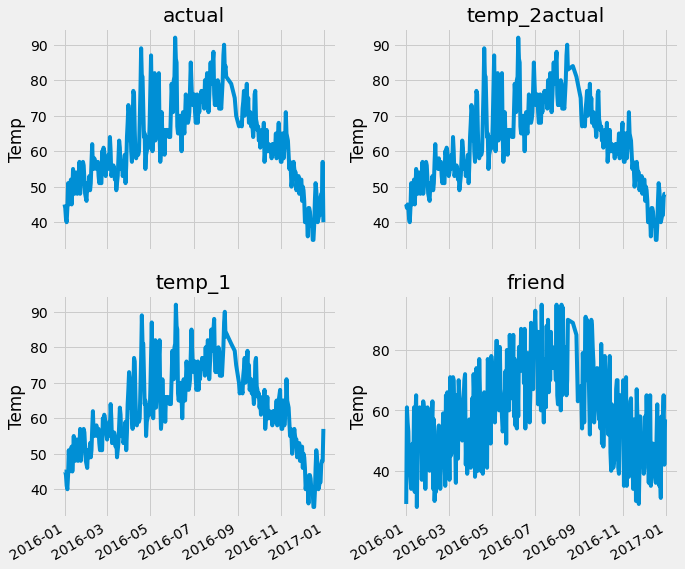

In [135]:
# 绘图展示
plt.style.use("fivethirtyeight")

# 布局
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
fig.autofmt_xdate()

ax1.plot(dates, features['actual'])
ax1.set_title('actual')
ax1.set_ylabel("Temp")

ax2.plot(dates, features['temp_2'])
ax2.set_title('temp_2actual')
ax2.set_ylabel("Temp")

ax3.plot(dates, features['temp_1'])
ax3.set_title('temp_1')
ax3.set_ylabel("Temp")

ax4.plot(dates, features['friend'])
ax4.set_title('friend')
ax4.set_ylabel("Temp")

In [136]:
# ont-hot编码
features = pd.get_dummies(features)
features.head()

,year,month,day,temp_2,temp_1,average,actual,friend,week_Fri,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed
0,2016,1,1,45,45,45.6,45,29,1,0,0,0,0,0,0
1,2016,1,2,44,45,45.7,44,61,0,0,1,0,0,0,0
2,2016,1,3,45,44,45.8,41,56,0,0,0,1,0,0,0
3,2016,1,4,44,41,45.9,40,53,0,1,0,0,0,0,0
4,2016,1,5,41,40,46.0,44,41,0,0,0,0,0,1,0


In [137]:
# 获得训练数据
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
y = np.array(features['actual'])
X = features.drop('actual',axis=1).to_numpy()
print(X[:2])
# 归一化
X = StandardScaler().fit_transform(X)
print(X[:2])

# 切分训练集和测试集
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.33, random_state=42)
features_name = features.columns.to_list()

# 改成 torch 格式
X_train = torch.from_numpy(X_train).to(torch.float32) # from numpy 会自动将numpy.float64转换成torch.float64，但是这里需要的是float32类型
y_train = torch.from_numpy(y_train).to(torch.float32)
X_test = torch.from_numpy(X_test).to(torch.float32)
y_test = torch.from_numpy(y_test).to(torch.float32)

[[2.016e+03 1.000e+00 1.000e+00 4.500e+01 4.500e+01 4.560e+01 2.900e+01
  1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [2.016e+03 1.000e+00 2.000e+00 4.400e+01 4.500e+01 4.570e+01 6.100e+01
  0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]]
[[ 0.         -1.5678393  -1.65682171 -1.48452388 -1.49443549 -1.3470703
  -1.98891668  2.44131112 -0.40482045 -0.40961596 -0.40482045 -0.40482045
  -0.41913682 -0.40482045]
 [ 0.         -1.5678393  -1.54267126 -1.56929813 -1.49443549 -1.33755752
   0.06187741 -0.40961596 -0.40482045  2.44131112 -0.40482045 -0.40482045
  -0.41913682 -0.40482045]]


In [138]:
X_train.dtype, X_train.shape

(torch.float32, torch.Size([233, 14]))

# 构建神经网络模型

In [139]:
# 基础参数初始化


epoch = 50
n_iters = 1000
learning_rate= 0.001
losses = []

# 权重参数初始化 - 构建两层神经网络模型
w1 = torch.randn((14,128), dtype=torch.float32, requires_grad=True)
b1 = torch.randn((128,), dtype=torch.float32, requires_grad=True)
w2 = torch.randn((128,1), dtype=torch.float32, requires_grad=True)
b2 = torch.randn((1,), dtype=torch.float32, requires_grad=True)

# 迭代
for iter in range(n_iters):
# forward
    hidden = X_train.mm(w1)+b1
    hidden_ = torch.relu(hidden)
    pred = hidden_.mm(w2)+b2

# 计算 loss
    loss = torch.mean((pred-y_train)**2)
    losses.append(loss.data.numpy())

# backward
    loss.backward()

# 更新权重参数
    w1.data.add_(-learning_rate * w1.grad.data)
    b1.data.add_(-learning_rate * b1.grad.data)
    w2.data.add_(-learning_rate * w2.grad.data)
    b2.data.add_(-learning_rate * b2.grad.data)

# 梯度重置
    w1.grad.data.zero_()
    b1.grad.data.zero_()
    w2.grad.data.zero_()
    b2.grad.data.zero_()
    
# 打印loss
    if not iter % epoch:
        print(f"第{iter+1}次循环: loss =", loss)

第1次循环: loss = tensor(5324.0244, grad_fn=<MeanBackward0>)
第51次循环: loss = tensor(160.7300, grad_fn=<MeanBackward0>)
第101次循环: loss = tensor(142.3184, grad_fn=<MeanBackward0>)
第151次循环: loss = tensor(137.3800, grad_fn=<MeanBackward0>)
第201次循环: loss = tensor(135.2348, grad_fn=<MeanBackward0>)
第251次循环: loss = tensor(134.0392, grad_fn=<MeanBackward0>)
第301次循环: loss = tensor(133.2544, grad_fn=<MeanBackward0>)
第351次循环: loss = tensor(132.6839, grad_fn=<MeanBackward0>)
第401次循环: loss = tensor(132.2460, grad_fn=<MeanBackward0>)
第451次循环: loss = tensor(131.9027, grad_fn=<MeanBackward0>)
第501次循环: loss = tensor(131.6364, grad_fn=<MeanBackward0>)
第551次循环: loss = tensor(131.4183, grad_fn=<MeanBackward0>)
第601次循环: loss = tensor(131.2346, grad_fn=<MeanBackward0>)
第651次循环: loss = tensor(131.0783, grad_fn=<MeanBackward0>)
第701次循环: loss = tensor(130.9426, grad_fn=<MeanBackward0>)
第751次循环: loss = tensor(130.8232, grad_fn=<MeanBackward0>)
第801次循环: loss = tensor(130.7187, grad_fn=<MeanBackward0>)
第851次循环: loss = 

# 数据处理

In [140]:
from sklearn.metrics import mean_squared_error
# 训练集得分
train_mse = mean_squared_error(y_train.data.numpy(),pred.data.ravel().numpy())

# 测试机得分
pred_testset = torch.relu(X_test.mm(w1)+b1).mm(w2)+b2
test_mse = mean_squared_error(y_test.data.numpy(),pred_testset.data.ravel().numpy())
print(train_mse, test_mse)

130.29695 163.8872


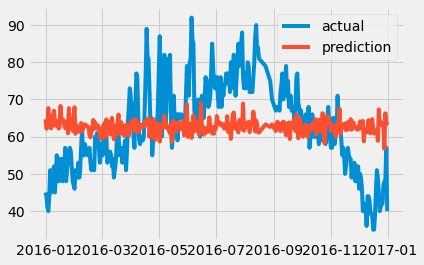

In [141]:
# 绘图
    # 预测
X_ = torch.tensor(X, dtype=torch.float32, requires_grad=True)
y_pred = torch.relu((X_.mm(w1)+b1)).mm(w2)+b2
y_pred = y_pred.view((-1))
    # tensor 转换成 Numpy
y_pred = y_pred.data.numpy()

    # 绘图
plt.plot(dates,y,label="actual")
plt.plot(dates,y_pred,label="prediction")
plt.legend()

## 更简单的方法构建模型

In [142]:
# 定义神经网络的类
class NeturalNet(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeturalNet,self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(input_size,hidden_size),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size,output_size),
        )
    def forward(self,X):
        out = self.layers(X).squeeze_(-1)
        return out

In [143]:
# 处理数据
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.33, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32, requires_grad=True)
X_test = torch.tensor(X_test, dtype=torch.float32, requires_grad=True)
y_train = torch.tensor(y_train, dtype=torch.float32, requires_grad=True)
y_test = torch.tensor(y_test, dtype=torch.float32, requires_grad=True)

In [144]:
# 类实例化
input_size = 14
hidden_size = 128
output_size = 1
net = NeturalNet(input_size, hidden_size, output_size)

# 损失函数
losses = []
cost = torch.nn.MSELoss(reduction='mean')

# 优化器
learning_rate = 0.001
optimizer = torch.optim.Adam(net.parameters(), learning_rate)

# 循环和batch_size
train_size = X_train.shape[0]
n_iters = 1000
batch_size = 20
iters_per_epoch = max(train_size / batch_size, 1)

In [145]:
# 训练
epoch=1
for iter in range(n_iters):
    # 训练的batch
    batch_mask = np.random.choice(train_size, batch_size)
    X_batch = X_train[batch_mask]
    y_batch = y_train[batch_mask]

    # forward
    out = net.forward(X_batch)

    # loss
    loss = cost(out,y_batch)

    # backward
    loss.backward()

    # 更新权重参数
    optimizer.step()

    # 梯度清零
    optimizer.zero_grad()

    losses.append(loss.data.numpy()) 

    if not (iter+1) % iters_per_epoch:
        epoch += 1
        print(f"the no.{iter+1} epoch: {epoch}, loss: {loss}")

the no.20 epoch: 2, loss: 4517.87841796875
the no.40 epoch: 3, loss: 3378.71630859375
the no.60 epoch: 4, loss: 3945.52490234375
the no.80 epoch: 5, loss: 3486.81689453125
the no.100 epoch: 6, loss: 3147.262451171875
the no.120 epoch: 7, loss: 2904.9609375
the no.140 epoch: 8, loss: 2773.58447265625
the no.160 epoch: 9, loss: 2736.58837890625
the no.180 epoch: 10, loss: 2439.258544921875
the no.200 epoch: 11, loss: 2084.70166015625
the no.220 epoch: 12, loss: 1660.0123291015625
the no.240 epoch: 13, loss: 1471.7310791015625
the no.260 epoch: 14, loss: 1376.086669921875
the no.280 epoch: 15, loss: 1044.709716796875
the no.300 epoch: 16, loss: 635.9834594726562
the no.320 epoch: 17, loss: 496.49456787109375
the no.340 epoch: 18, loss: 327.700927734375
the no.360 epoch: 19, loss: 387.023681640625
the no.380 epoch: 20, loss: 247.8526153564453
the no.400 epoch: 21, loss: 251.7017059326172
the no.420 epoch: 22, loss: 180.69119262695312
the no.440 epoch: 23, loss: 174.99893188476562
the no.46

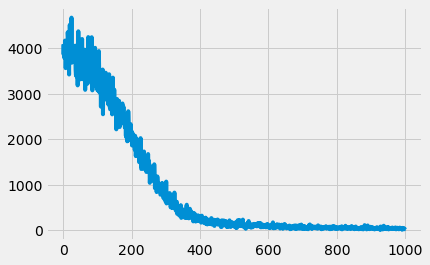

In [146]:
# loss下降趋势
plt.plot(range(len(losses)), losses)

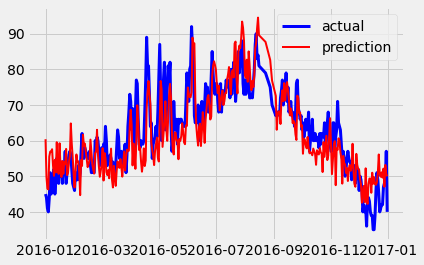

In [147]:
y_pred = net.forward(torch.tensor(X, dtype=torch.float32)).data.numpy()
plt.plot(dates, y, 'b-', label="actual", lw=3)
plt.plot(dates, y_pred, 'r-', label="prediction", lw=2)
plt.legend()